# MS002 Preprocess
Created: 01/25/2024 \
Last Update: 04/07/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS002'
subj_format = ['edf']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [6]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/raw/MS002_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2219007  =      0.000 ...  2166.999 secs...


In [7]:
mne_data

<RawEDF | MS002_SWB.edf, 276 x 2219008 (2167.0 s), ~4.56 GB, data loaded>

In [8]:
# mne_data.ch_names

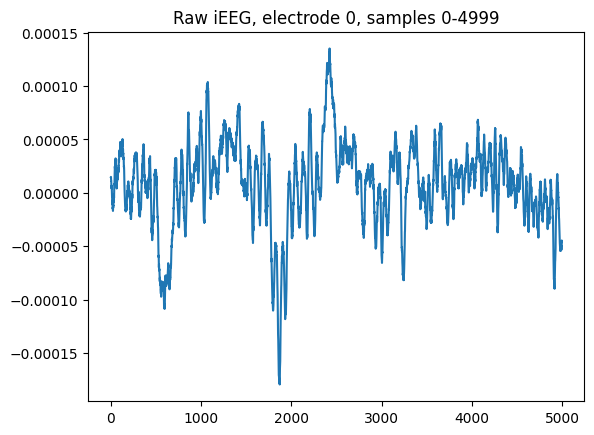

In [8]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Photodiode
- examine photodiode 

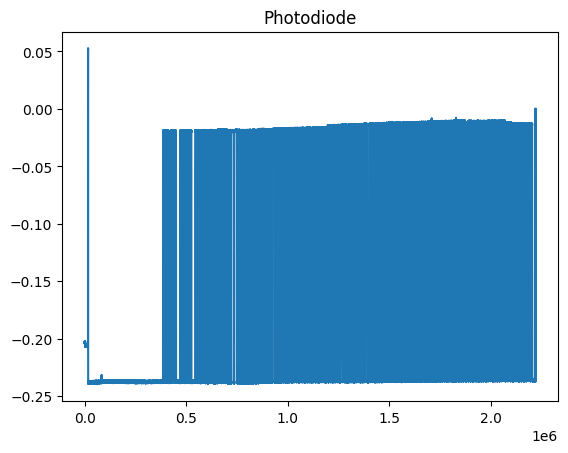

In [9]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [10]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/photodiode.fif
[done]


In [11]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS002_SWB.edf, 275 x 2219008 (2167.0 s), ~4.55 GB, data loaded>

### Resampling data 

In [9]:
#resampling if patient is not sampled at 512
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:   36.5s finished


<RawEDF | MS002_SWB.edf, 276 x 1083500 (2167.0 s), ~2.23 GB, data loaded>

### Notch filter line noise

In [10]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:    9.1s finished


<RawEDF | MS002_SWB.edf, 276 x 1083500 (2167.0 s), ~2.23 GB, data loaded>

### Anatomical Localization

In [11]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS002_SWB.edf, 276 x 1083500 (2167.0 s), ~2.23 GB, data loaded>

In [12]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination
0,LaCaS1,A32sg_L,-6.784557,49.555827,0.149337,-6.382462,37.158688,-3.130044,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus D,NaN
1,LaCaS10,A9l_L,-8.380923,61.155821,43.676991,-8.220073,48.757099,44.868611,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Medial Gyrus,L SFG,Left superior frontal gyrus 2 C,NaN
2,LaCaS11,A9l_L,-8.780014,62.355821,48.469026,-8.542609,49.887710,50.203768,Unknown,Left SFG superior frontal gyrus,Unknown,L Superior Medial Gyrus,L SFG,Left superior frontal gyrus 2 C,OOB
3,LaCaS12,Unknown,-8.780014,63.555820,53.261062,-8.436667,51.044299,55.539730,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB
4,LaCaS2,A32sg_L,-6.784557,50.755827,4.941372,-6.368174,38.606223,2.270621,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,RmOIF5,A12/47o_R,33.922762,42.355831,-8.636061,34.666463,28.882016,-13.444118,White,Right Cerebral White Matter,Unknown,R IFG (p Orbitalis),R OrG,Right frontal orbital 4 D,WM
154,RmOIF6,A12/47l_R,37.913675,41.555831,-6.240044,38.716568,28.139395,-11.063832,Gray,Right Cerebral White Matter,Unknown,R IFG (p Orbitalis),R OrG,Right frontal orbital 4 D,NaN
155,RmOIF7,A12/47l_R,41.904589,40.755832,-3.844026,42.794042,27.279509,-8.584441,Gray,Right OrIFG orbital part of the inferior front...,Unknown,R IFG (p Orbitalis),R OrG,Right pars orbitalis C,NaN
156,RmOIF8,A12/47l_R,46.294594,39.555832,-1.048672,47.308597,25.926043,-5.816665,Gray,Right OrIFG orbital part of the inferior front...,Unknown,R IFG (p Orbitalis),R OrG,Right middle pars triangularis B,NaN


In [16]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAgIT1',
 'LAgIT10',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LaImS1',
 'LaImS10',
 'LaImS11',
 'LaImS12',
 'LaImS13',
 'LaImS14',
 'LaImS2',
 'LaImS3',
 'LaImS4',
 'LaImS5',
 'LaImS6',
 'LaImS7',
 'LaImS8',
 'LaImS9',
 'LHplT1',
 'LHplT10',
 'LHplT11',
 'LHplT12',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LlOiF1',
 'LlOiF10',
 'LlOiF2',
 'LlOiF3',
 'LlOiF4',
 'LlOiF5',
 'LlOiF6',
 'LlOiF7',
 'LlOiF8',
 'LlOiF9',
 'LmOIF1',
 'LmOIF10',
 'LmOIF11',
 'LmOIF12',
 'LmOIF13',
 'LmOIF14',
 'LmOIF2',
 'LmOIF3',
 'LmOIF4',
 'LmOIF5',
 'LmOIF6',
 'LmOIF7',
 'LmOIF8',
 'LmOIF9',
 'LpIpS1',
 'LpIpS10',
 'LpIpS11',
 'LpIpS12',
 'LpIpS13',
 'LpIpS14',
 'LpIpS2',
 'LpIpS3',
 'LpIpS4',
 'LpIpS5',
 'LpIpS6',
 'LpIpS7',
 'LpIpS8',
 'LpIpS9',
 'LsiF1',
 'LsiF2',
 'LsiF3',
 

In [13]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['lmolf1', 'lmolf2', 'lmolf3', 'lmolf4', 'lmolf5', 'lmolf6', 'lmolf7', 'lmolf8', 'lmolf9', 'lmolf10', 'lmolf11', 'lmolf12', 'lmolf13', 'lmolf14', 'rmolf1', 'rmolf2', 'rmolf3', 'rmolf4', 'rmolf5', 'rmolf6', 'rmolf7', 'rmolf8', 'rmolf9', 'rmolf10', 'rmolf11', 'rmolf12', 'c63', 'c64', 'lalms1', 'lalms2', 'lalms3', 'lalms4', 'lalms5', 'lalms6', 'lalms7', 'lalms8', 'lalms9', 'lalms10', 'lalms11', 'lalms12', 'lalms13', 'lalms14', 'ralms1', 'ralms2', 'ralms3', 'ralms4', 'ralms5', 'ralms6', 'ralms7', 'ralms8', 'ralms9', 'ralms10', 'ralms11', 'ralms12', 'ralms13', 'ralms14', 'lslif1', 'lslif2', 'lslif3', 'lslif4', 'lslif5', 'lslif6', 'lslif7', 'lslif8', 'lplps1', 'lplps2', 'lplps3', 'lplps4', 'lplps5', 'lplps6', 'lplps7', 'lplps8', 'lplps9', 'lplps10', 'lplps11', 'lplps12', 'lplps13', 'lplps14', 'laglt1', 'laglt2', 'laglt3', 'laglt4', 'laglt5', 'laglt6', 'laglt7', 'laglt8', 'laglt9', 'laglt10', 'c125', 'c126', 'c127', 'c128', 'raglt1', 'raglt2', 'raglt3', 'raglt4', 'raglt5', 'raglt6', 'raglt7',

In [15]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file
       name  lev_score
274  lloif6   0.833333
275  lmolf6   0.833333
We have too many possible matches for lmoif6! Select one manually from these candidates:lmolf6
        name  lev_score
274  lloif10   0.857143
275  lmolf10   0.857143
We have too many possible matches for lmoif10! Select one manually from these candidates:lmolf10
       name  lev_score
274  lloif1   0.833333
275  lmolf1   0.833333
We have too many possible matches for lmoif1! Select one manually from these candidates:lmolf1
       name  lev_score
274  lloif8   0.833333
275  lmolf8   0.833333
We have too many possible matches for lmoif8! Select one manually from these candidates:lmolf8
       name  lev_score
274  lloif4   0.833333
275  lmolf4   0.833333
We have too many possible matches for lmoif4! Select one manually from these candidates:lmolf4
       name  lev_score
274  lloif2   0.833333
275  lmolf2   0.833333
We 

In [16]:
unmatched_seeg #make sure there are no unmatched names


[]

In [17]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [18]:
new_name_dict #make sure this passes the eye test 


{'lloif1': 'lloif1',
 'lloif2': 'lloif2',
 'lloif3': 'lloif3',
 'lloif4': 'lloif4',
 'lloif5': 'lloif5',
 'lloif6': 'lloif6',
 'lloif7': 'lloif7',
 'lloif8': 'lloif8',
 'lloif9': 'lloif9',
 'lloif10': 'lloif10',
 'lmolf1': 'lmoif1',
 'lmolf2': 'lmoif2',
 'lmolf3': 'lmoif3',
 'lmolf4': 'lmoif4',
 'lmolf5': 'lmoif5',
 'lmolf6': 'lmoif6',
 'lmolf7': 'lmoif7',
 'lmolf8': 'lmoif8',
 'lmolf9': 'lmoif9',
 'lmolf10': 'lmoif10',
 'lmolf11': 'lmoif11',
 'lmolf12': 'lmoif12',
 'lmolf13': 'lmoif13',
 'lmolf14': 'lmoif14',
 'rmolf1': 'rmoif1',
 'rmolf2': 'rmoif2',
 'rmolf3': 'rmoif3',
 'rmolf4': 'rmoif4',
 'rmolf5': 'rmoif5',
 'rmolf6': 'rmoif6',
 'rmolf7': 'rmoif7',
 'rmolf8': 'rmoif8',
 'rmolf9': 'rmoif9',
 'rmolf10': 'rmoif10',
 'rmolf11': 'rmoif11',
 'rmolf12': 'rmoif12',
 'lacas1': 'lacas1',
 'lacas2': 'lacas2',
 'lacas3': 'lacas3',
 'lacas4': 'lacas4',
 'lacas5': 'lacas5',
 'lacas6': 'lacas6',
 'lacas7': 'lacas7',
 'lacas8': 'lacas8',
 'lacas9': 'lacas9',
 'lacas10': 'lacas10',
 'lacas11': 'l

In [19]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS002_SWB.edf, 276 x 1083500 (2167.0 s), ~2.23 GB, data loaded>

In [21]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 94 left sEEG and 64 right sEEG electrodes
We have a total of 158 sEEG electrodes


In [22]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS002_SWB.edf, 276 x 1083500 (2167.0 s), ~2.23 GB, data loaded>

In [23]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS002_SWB.edf, 158 x 1083500 (2167.0 s), ~1.28 GB, data loaded>

In [24]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS002_SWB.edf, 158 x 1083500 (2167.0 s), ~1.28 GB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [25]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [26]:
probe_names

array(['lacas', 'lagit', 'laims', 'lhplt', 'lloif', 'lmoif', 'lpips',
       'lsif', 'racas', 'ragit', 'raims', 'rhplt', 'rmoif'], dtype='<U5')

In [27]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [28]:
probe_ch_counts

{'lacas': 12,
 'lagit': 10,
 'laims': 14,
 'lhplt': 12,
 'lloif': 10,
 'lmoif': 14,
 'lpips': 14,
 'lsif': 8,
 'racas': 14,
 'ragit': 12,
 'raims': 14,
 'rhplt': 12,
 'rmoif': 12}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [31]:
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict)
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
# mne_data.info['bads']

['lacas11',
 'laims6',
 'lloif2',
 'lmoif1',
 'lmoif11',
 'lmoif2',
 'ragit3',
 'rhplt11',
 'rhplt2']

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


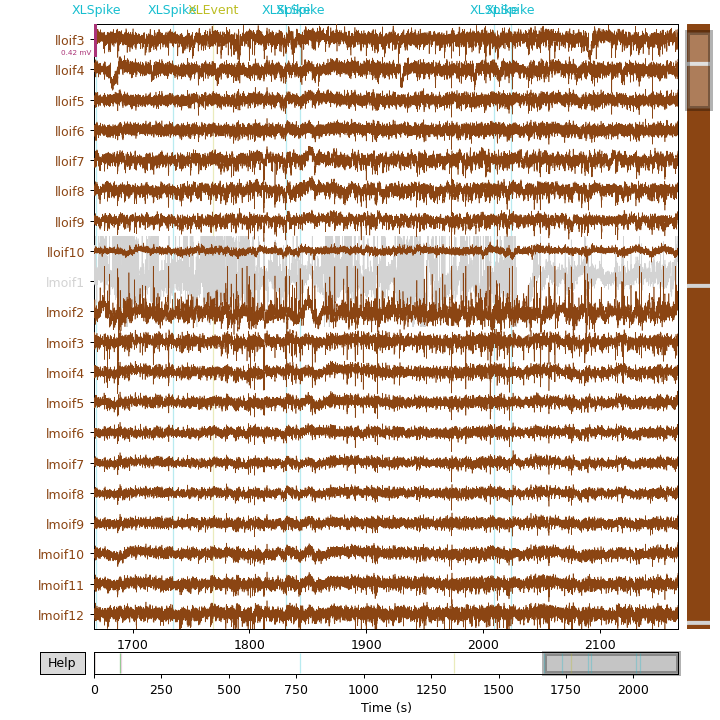

<IPython.core.display.Javascript object>


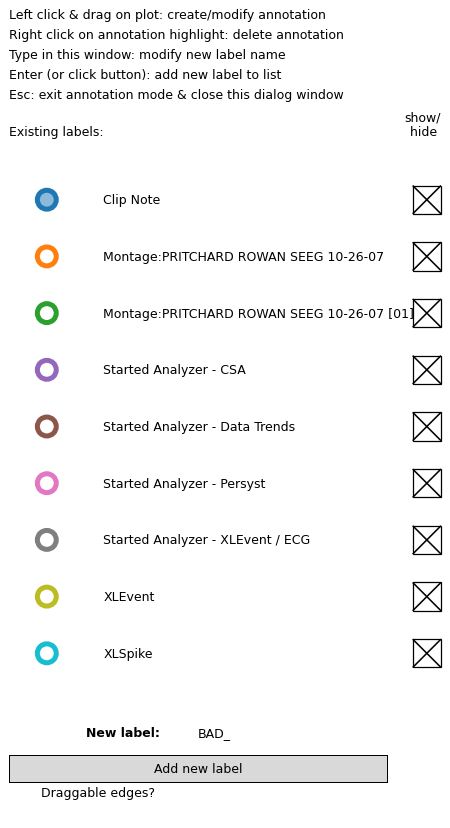

In [33]:
 %matplotlib notebook
fig = mne_data.plot(start=0, duration=500, n_channels=20, scalings=mne_data._data.max()/50)
fig.fake_keypress('a')

In [29]:
# #add manually for situations where raw data needs to be updated but manual bad channel inspection does not change 

mne_data.info['bads'] = ['lmoif1', 'laims7', 'rhplt11'] #04/07/2024

In [34]:
mne_data.info['bads']

#previous: ['lmoif1', 'lmoif2', 'lloif4', 'laims7', 'rhplt11', 'rhplt5']


['lmoif1', 'laims7', 'rhplt11']

In [30]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 3 items (lmoif1, laims7, rhplt11)
 ch_names: lloif1, lloif2, lloif3, lloif4, lloif5, lloif6, lloif7, lloif8, ...
 chs: 158 sEEG
 custom_ref_applied: False
 dig: 158 items (158 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: 2001-01-01 15:59:08 UTC
 nchan: 158
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [31]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [32]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=94, n_times=1083500
    Range : 0 ... 1083499 =      0.000 ...  2166.998 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas3-lacas4, lacas4-lacas5, lacas5-lacas6, lacas6-lacas7, lacas7-lacas8, lacas8-lacas9, lacas9-lacas10, lagit1-lagit2, lagit2-lagit3, lagit3-lagit4, lagit6-lagit7, lagit7-lagit8, lagit8-lagit9, laims1-laims2, laims2-laims3, laims3-laims4, laims4-laims5, laims5-laims6, laims6-laims8, laims10-laims11, laims11-laims12, laims12-laims13, laims13-laims14, lhplt1-lhplt2, lhplt2-lhplt3, lhplt3-lhplt4, lhplt4-lhplt5, lhplt8-lhplt9, lhplt9-lhplt10, lhplt10-lhplt11, lhplt11-lhplt12, lloif1-lloif2, lloif2-lloif3, lloif3-lloif4, lloif6-lloif7, lloif7-lloif8, lloif8-lloif9, lmoif2-lmoif3, lmoif8-lmoif9, lmoif9-lmoif10, lmoif10-lmoif11, lmoif11-lmoif12, lmoif12-lmoif13, lpips1-lpips2, lpips2-lpips3, lpips3-lpips4, lpips4-lpips5, lpips9-lpips10, lpips10-lpi

In [33]:
mne_data_bp_reref

<RawEDF | MS002_SWB.edf, 94 x 1083500 (2167.0 s), ~777.2 MB, data loaded>

<IPython.core.display.Javascript object>


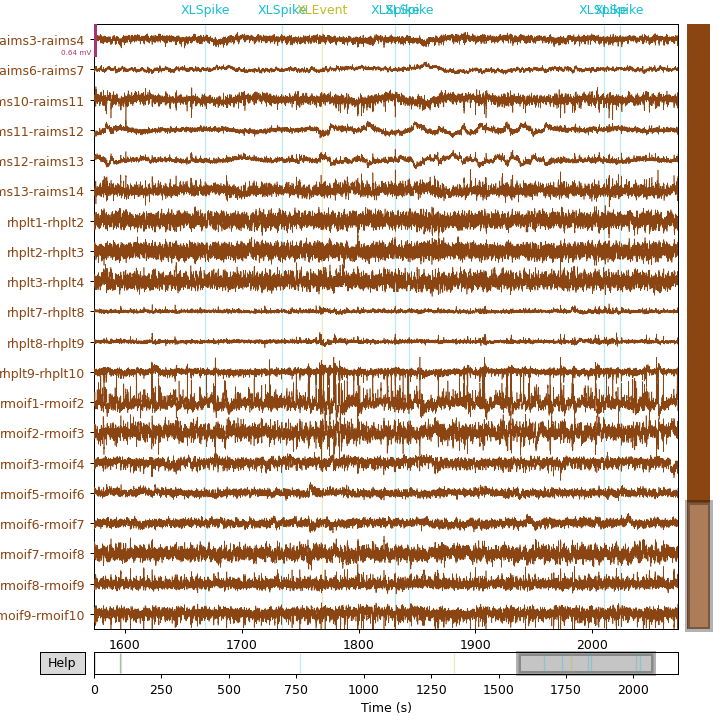

<IPython.core.display.Javascript object>


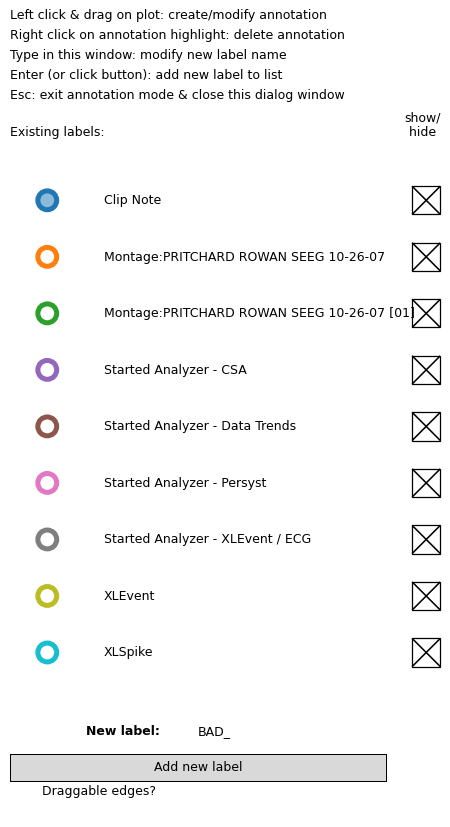

In [39]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=500, n_channels=20, scalings=mne_data_bp_reref._data.max()/5)
fig.fake_keypress('a')

In [34]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas2-lacas3',
 'lacas3-lacas4',
 'lacas4-lacas5',
 'lacas5-lacas6',
 'lacas6-lacas7',
 'lacas7-lacas8',
 'lacas8-lacas9',
 'lacas9-lacas10',
 'lagit1-lagit2',
 'lagit2-lagit3',
 'lagit3-lagit4',
 'lagit6-lagit7',
 'lagit7-lagit8',
 'lagit8-lagit9',
 'laims1-laims2',
 'laims2-laims3',
 'laims3-laims4',
 'laims4-laims5',
 'laims5-laims6',
 'laims6-laims8',
 'laims10-laims11',
 'laims11-laims12',
 'laims12-laims13',
 'laims13-laims14',
 'lhplt1-lhplt2',
 'lhplt2-lhplt3',
 'lhplt3-lhplt4',
 'lhplt4-lhplt5',
 'lhplt8-lhplt9',
 'lhplt9-lhplt10',
 'lhplt10-lhplt11',
 'lhplt11-lhplt12',
 'lloif1-lloif2',
 'lloif2-lloif3',
 'lloif3-lloif4',
 'lloif6-lloif7',
 'lloif7-lloif8',
 'lloif8-lloif9',
 'lmoif2-lmoif3',
 'lmoif8-lmoif9',
 'lmoif9-lmoif10',
 'lmoif10-lmoif11',
 'lmoif11-lmoif12',
 'lmoif12-lmoif13',
 'lpips1-lpips2',
 'lpips2-lpips3',
 'lpips3-lpips4',
 'lpips4-lpips5',
 'lpips9-lpips10',
 'lpips10-lpips11',
 'lpips11-lpips12',
 'lpips12-lpips13',
 'lsif3-lsif4',
 '

Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


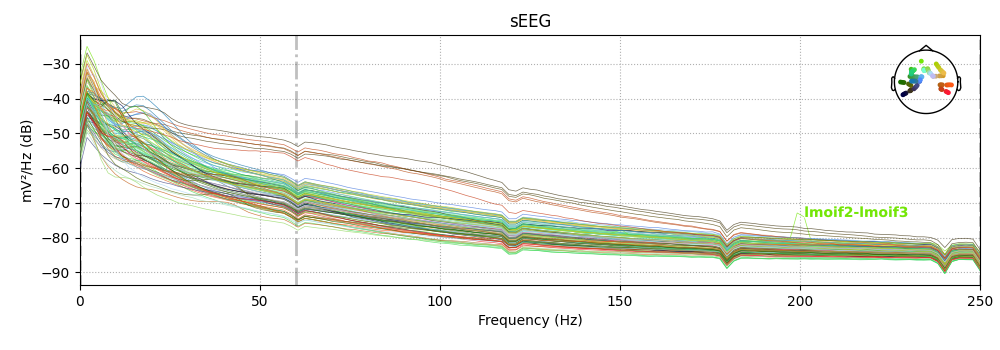

<IPython.core.display.Javascript object>


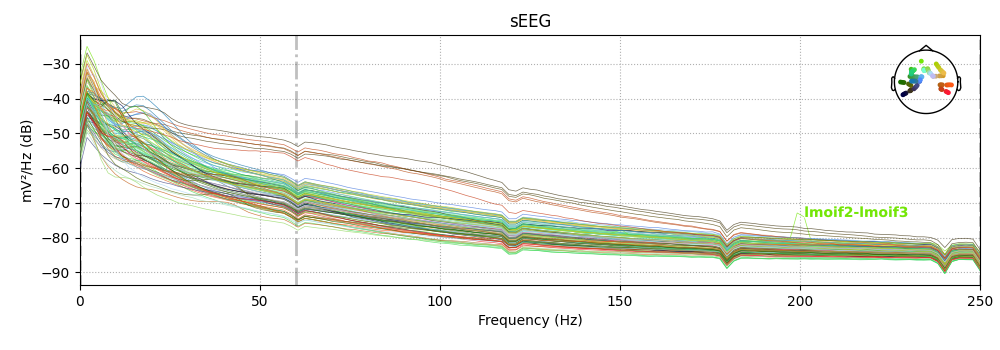

In [41]:
# %matplotlib notebook
# mne_data_bp_reref.plot_psd(picks=['lacas1-lacas2'])
mne_data_bp_reref.compute_psd().plot()

In [35]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/bp_ref_ieeg.fif
[done]


## Save mne_data

In [36]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [37]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [38]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/photodiode.fif...
Isotrak not found
    Range : 0 ... 2219007 =      0.000 ...  2166.999 secs
Ready.
Reading 0 ... 2219007  =      0.000 ...  2166.999 secs...


In [39]:
photodiode_data

<Raw | photodiode.fif, 1 x 2219008 (2167.0 s), ~16.9 MB, data loaded>

In [44]:
#### verify photodiode alignment
    # requires newer functions from new sync utils package (older version used here)

def get_neural_ts_photodiode(mne_sync, smoothSize=11, height=0.5):
    """
    get neural ts from photodiode
    """

    sig = np.squeeze(moving_average(mne_sync._data, n=smoothSize))
    timestamp = np.squeeze(np.arange(len(sig))/mne_sync.info['sfreq'])
    sig = scipy.stats.zscore(sig)

    trig_ix = np.where((sig[:-1]<=height)*(sig[1:]>height))[0] # rising edge of trigger
    
    neural_ts = timestamp[trig_ix]
    neural_ts = np.array(neural_ts)

    return neural_ts


def moving_average(a, n=11) :
    """
    Computes the moving average of a given array a with a window size of n.

    Parameters
    ----------
    a : np.ndarray
        The input array to compute the moving average on.
    n : int, optional
        The window size of the moving average. Default is 11.

    Returns
    -------
    np.ndarray
        The moving average of the input array a.
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n




In [41]:
temp_diode = photodiode_data.copy()
temp_diode._data[0,0:100000] = np.min(temp_diode._data[0,:])


In [42]:

# moving_average
neural_ts = get_neural_ts_photodiode(temp_diode, smoothSize=15, height=0.7)
neural_ts.shape




(162,)

In [46]:
pulses = [(x*slope + offset) for x in beh_ts]
len(pulses)

149

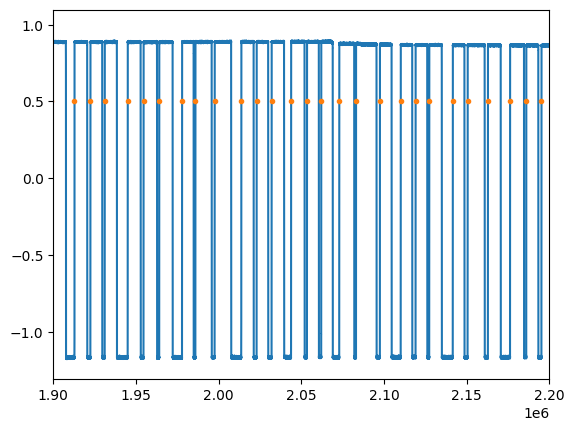

In [47]:
# # plt.plot(neural_ts,'o')
# plt.plot(pulses,'o')
# plt.show()

plt.plot(scipy.stats.zscore(temp_diode._data[0,:]))
# plt.plot(pulses)
plt.plot(np.array(pulses)*1024, 
         np.ones_like(np.array(pulses)*1024)-0.5, '.')
# plt.plot(neural_ts*1024, 
#          np.ones_like(neural_ts)-0.25, '.')
plt.xlim([1900000,2200000])
plt.show()

In [45]:
### Photodiode alignment
smoothSize=11
windSize=15
height=0.7


# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

10 blocks
..........

found matches for 120 of 162 pulses
8 blocks
........

found matches for 100 of 162 pulses


In [48]:
print(slope, offset,smoothSize,windSize,height)

0.9999813516108821 17.500976136008376 11 15 0.7


In [51]:
[(x*slope + offset) for x in beh_ts]

[530.8722091659727,
 540.1322982638679,
 548.6660777761928,
 563.0836146691986,
 572.8281516861812,
 581.36259858572,
 594.5398892390037,
 603.7221906271329,
 612.5990117675659,
 627.1320058486746,
 637.715497493208,
 646.6819868158043,
 661.2028719288941,
 670.632233183922,
 679.3254551416941,
 694.7525196944612,
 704.6667366607642,
 719.3641895912203,
 749.9460716123841,
 759.095507330146,
 772.8851712517587,
 782.5557603854115,
 791.5608517684819,
 805.2903936418945,
 813.8409617325908,
 824.364642622959,
 838.4447035812326,
 847.4240812569143,
 855.7665601341207,
 878.5853562782356,
 887.4460110283785,
 901.6148629856167,
 914.2788497726278,
 922.592565900862,
 937.4662237556347,
 946.2004050287192,
 955.5642252393664,
 969.0755815927131,
 977.7766133008702,
 986.0716577868121,
 1001.1263304737529,
 1009.5038692792908,
 1018.924777696259,
 1032.209843884807,
 1040.8154260215588,
 1049.2306640048669,
 1062.3292564658263,
 1070.5197698543461,
 1079.3108622371456,
 1093.2456177791337,

In [837]:
# del epochs_all_baseline, power_epochs, plot_data

## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [49]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [50]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [51]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [52]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values,downsamp_factor=None,
#                  behav_name=event, behav_times=beh_ts,downsamp_factor=None,
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/bp_ref_ieeg.fif...
    Range : 0 ... 1083499 =      0.000 ...  2166.998 secs
Ready.
Reading 0 ... 1083499  =      0.000 ...  2166.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  91 out of  94 | elapsed:    4.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    4.4s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
149 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 149 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 94 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS002/bp_ref_ieeg.fif...
    Range : 0 ... 1083499 =      0.000 ...  2166.998 secs
Ready.
Reading 0 ... 1083499  =      0.000 ...  2166.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  91 out of  94 | elapsed:    5.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  94 out of  94 | elapsed:    5.1s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
149 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 149 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 94 columns


In [53]:
epochs_all_evs 


{'TrialOnset': <Epochs |  149 events (all good), -2 - 1 sec, baseline off, ~160.5 MB, data loaded, with metadata,
  'TrialOnset': 149>,
 'DecisionOnset': <Epochs |  149 events (all good), -1 - 6 sec, baseline off, ~374.3 MB, data loaded, with metadata,
  'DecisionOnset': 149>}

### Add behavioral data to metadata 

In [54]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE']

In [55]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 116 columns
Replacing existing metadata with 116 columns


In [56]:
epochs_all_evs[event].metadata

,lacas1-lacas2,lacas2-lacas3,lacas3-lacas4,lacas4-lacas5,lacas5-lacas6,lacas6-lacas7,lacas7-lacas8,lacas8-lacas9,lacas9-lacas10,lagit1-lagit2,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.57,-0.57,-0.57,-0.57,0.00,0.00,0.57,0.57,0.00,0.000
1,NaN,noise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.95,-0.65,-0.95,-0.65,0.00,0.00,0.00,-0.30,0.00,-0.475
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.68,1.28,0.00,0.00,1.68,1.28,0.00,0.40,0.84,0.000
3,NaN,NaN,noise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.80,0.80,0.00,0.00,0.80,0.80,-0.80,-0.80,0.00,0.000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.24,0.74,0.00,0.00,1.24,0.74,0.00,0.50,0.62,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.24,0.50,0.00,0.00,1.24,0.50,-1.24,-0.50,0.62,0.000
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.16,-0.16,-0.16,-0.16,0.00,0.00,0.16,0.16,0.00,0.000
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.40,-0.90,-1.40,-0.90,0.00,0.00,0.00,-0.50,0.00,-0.700
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.84,-0.30,-0.84,-0.30,0.00,0.00,0.84,0.30,0.00,-0.420


### Save raw epoched data 

In [57]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


### Baseline + Decompose into TFRs

In [58]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

baseline_ev = 'TrialOnset'
analysis_evs = ['DecisionOnset']

evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [59]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))
# buf = 1.0
# buf_ix = int(buf*sr)

In [60]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [61]:
#baseline epoch - 
event = 'TrialOnset' #or baseline_ev
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

### this is new!
good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                         freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]

# for ch_ix in np.arange(epochs._data.shape[1]): 
#     ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
#     bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
#     good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
#     ch_data = np.delete(ch_data, bad_epochs, axis=0)
#     ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
#                                         freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
#                                         use_fft=True, output='power', n_jobs=1)

#     pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [62]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 149, channels : 94, ~1.57 GB>}

In [63]:
power_epochs = {}

In [64]:
event = 'DecisionOnset' # or analysis_evs

epochs = epochs_all_evs[event]

ch_names = epochs.ch_names

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names):
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'].data, 
                                                  mode='zscore',ev_axis=0,elec_axis=1,
                                                  freq_axis=2,time_axis=3)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


Not setting metadata
Adding metadata with 116 columns


In [65]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 149, channels : 94, ~7.83 GB>

In [66]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [ ]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)

In [67]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')
print(date)

04072024


In [68]:
event = 'DecisionOnset'
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    # same for all elec
    times = power_epochs[event].times
    # single ch tfr 
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), 
                   vmax = np.nanmax(np.abs(plot_data)))
    

    ax.set(xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding',
           yticks=np.arange(0,len(freqs))[::5], 
           yticklabels=freqs[::5].astype(int), 
           xticks = np.arange(plot_data.shape[1])[::250],
              xticklabels= times[::250])
    fig.colorbar(im, ax=ax)
    
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
    plt.close()


17.500976136008376
